In [167]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.feature import hog
from skimage import exposure
import keras_tuner as kt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from skimage import exposure
from skimage import color
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion
from skimage.measure import regionprops, find_contours
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV


from utils import *
from feature_util import *





In [10]:
# Load the image paths and labels from the DataFrame
df = pd.read_csv('Dataset/cards.csv')

# For column names that contain space, replace the space with an underscore
df.columns = [c.replace(' ', '_') for c in df.columns]

# Add suits column
df['suit'] = df['labels'].str.split().str[-1]

# Remove rows with jokers
df = df[~df['suit'].str.contains('joker', case=False)]

# Remove unwanted columns
df = df.drop(columns = ['data_set'])
df = df.drop(columns = ['class_index'])
df = df.drop(columns = ['labels'])
df = df.drop(columns = ['card_type'])

# Add folder name to the filepath
df['filepaths'] = df['filepaths'].apply(lambda x: 'Dataset/' + x)
df.head()

,filepaths,suit
0,Dataset/train/ace of clubs/001.jpg,clubs
1,Dataset/train/ace of clubs/002.jpg,clubs
2,Dataset/train/ace of clubs/003.jpg,clubs
3,Dataset/train/ace of clubs/004.jpg,clubs
4,Dataset/train/ace of clubs/005.jpg,clubs


In [11]:
# Split dataframe into train and test sets, stratified by the 'suit' column
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['suit'], random_state=42)

# Split train set into train and validation sets, stratified by the 'suit' column
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['suit'], random_state=42)

# Check class distribution in the train, validation, and test sets
train_class_distribution = train_df['suit'].value_counts(normalize=True)
val_class_distribution = val_df['suit'].value_counts(normalize=True)
test_class_distribution = test_df['suit'].value_counts(normalize=True)

print("Train Set - Class Distribution:")
print(train_class_distribution)

print("Validation Set - Class Distribution:")
print(val_class_distribution)

print("Test Set - Class Distribution:")
print(test_class_distribution)

Train Set - Class Distribution:
spades      0.269171
hearts      0.246010
diamonds    0.243675
clubs       0.241144
Name: suit, dtype: float64
Validation Set - Class Distribution:
spades      0.269261
hearts      0.245914
diamonds    0.243580
clubs       0.241245
Name: suit, dtype: float64
Test Set - Class Distribution:
spades      0.268991
hearts      0.245953
diamonds    0.244085
clubs       0.240971
Name: suit, dtype: float64


## Augment Images

In [12]:
# Initialize data generator class

train_data_generator = ImageDataGenerator(
    #rescale = 1/255.0,   #Want 0 to 255 values for the color histogram
#     rotation_range= 45,
#     zoom_range= 0.2,
#     width_shift_range = 0.2,
#     height_shift_range = 0.2,
#     shear_range= 0.2,
#     horizontal_flip=True,
#     vertical_flip=True
# 
)
test_data_generator = ImageDataGenerator() #rescale = 1/255.0) #want 0 to 255 values for the color histogram

# Create data generators for train, validation, and test
batch_size = 32

train_generator = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle=False
)

valid_generator = test_data_generator.flow_from_dataframe( #change this to use test_data_generator since don't want to augment the valid images
    dataframe = val_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle=False
)

test_generator = test_data_generator.flow_from_dataframe( #change this to use test_data_generator since don't want to augment the valid images
    dataframe = test_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle=False
)


Found 5138 validated image filenames belonging to 4 classes.
Found 1285 validated image filenames belonging to 4 classes.
Found 1606 validated image filenames belonging to 4 classes.


### Functions

In [18]:

def hist_hsv(image, channel = 0):
    
  # Convert the image from RGB to HSV
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Calculate histograms for each channel (hsv, Saturation, Value)
    hist_hsv = cv2.calcHist([image_hsv], [channel], None, [256], [0, 256]).flatten().astype(np.uint8)

    # Normalize histograms with area under curve
    hist_hsv_normalized = (hist_hsv / np.sum(hist_hsv))
    
    # Scale the normalized histograms to have values between 0 and 255
    hist_hsv_scaled = (hist_hsv_normalized * 255).astype(np.uint8)
    
    return hist_hsv_scaled


# Function to compute hsv features for a batch of images
def extract_hsv_features_from_generator(data_generator, channel = 0):
    hsv_features = []
    labels = []
    num_batches = len(data_generator)
    
    for _ in range(num_batches):
        batch_images, class_labels = data_generator.next()  # Get the next batch of augmented images (ignoring the labels)
        
        # Compute hsv features for each image in the batch
        for image, label in zip(batch_images,class_labels):
            hsv_feature = hist_hsv(image,channel)
            hsv_features.append(hsv_feature)
            label = list(label)
            labels.append(label)
            
    return np.array(hsv_features),labels




In [147]:
def compute_class_accuracies(model, features, labels):
    # Predict using the provided model
    predictions = model.predict(features)
    if model == cnn:
        predictions = np.argmax(predictions,axis=1)
    # Calculate accuracy for each class
    class_accuracies = []
    unique_classes = np.unique(labels)    

    
    for class_label in unique_classes:
        class_indices = np.where(labels == class_label)
        class_predictions = predictions[class_indices]
        correct_predictions = np.sum(class_predictions == class_label)
        total_samples = len(class_indices[0])
        accuracy = np.round(correct_predictions / total_samples,4)
        class_accuracies.append(accuracy)

    correct_predictions = np.sum(predictions == labels)
    total_samples = len(labels)
    accuracy = np.round(correct_predictions / total_samples,4)
    
    class_accuracies.append(accuracy)
    
    return class_accuracies

### Hue feature vector

In [69]:

train_hsv_features, train_labels = extract_hsv_features_from_generator(train_generator, channel = 0)
valid_hsv_features, valid_labels = extract_hsv_features_from_generator(valid_generator,channel = 0)
test_hsv_features, test_labels = extract_hsv_features_from_generator(test_generator, channel = 0)

train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)
test_labels = np.array(test_labels)

<ipython-input-18-cca07e127b0b>:10: RuntimeWarning: invalid value encountered in true_divide
  hist_hsv_normalized = (hist_hsv / np.sum(hist_hsv))


### CNN Classification - Hue

In [72]:
# cnn using the train hsv features
num_classes = 4

cnn = Sequential()
cnn.add(Dense(128, activation='relu', input_shape=(train_hsv_features.shape[1],)))
cnn.add(Dropout(0.03))
cnn.add(Dense(64, activation='relu'))
cnn.add(Dropout(0.03))
cnn.add(Dense(num_classes, activation='softmax'))

cnn.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [73]:
# Train the CNN model
cnn.fit(train_hsv_features, train_labels,
                    batch_size=16,
                    epochs=20,
                    validation_data=(valid_hsv_features, valid_labels))


Epoch 1/20
322/322 [==============================] - 1s 3ms/step - loss: 1.8355 - accuracy: 0.3447 - val_loss: 1.3886 - val_accuracy: 0.3798
Epoch 2/20
322/322 [==============================] - 1s 2ms/step - loss: 1.3756 - accuracy: 0.4039 - val_loss: 1.2901 - val_accuracy: 0.3922
Epoch 3/20
322/322 [==============================] - 1s 2ms/step - loss: 1.2926 - accuracy: 0.4247 - val_loss: 1.2544 - val_accuracy: 0.4031
Epoch 4/20
322/322 [==============================] - 1s 2ms/step - loss: 1.2191 - accuracy: 0.4510 - val_loss: 1.2315 - val_accuracy: 0.4062
Epoch 5/20
322/322 [==============================] - 1s 2ms/step - loss: 1.1990 - accuracy: 0.4484 - val_loss: 1.2150 - val_accuracy: 0.4179
Epoch 6/20
322/322 [==============================] - 1s 2ms/step - loss: 1.1594 - accuracy: 0.4726 - val_loss: 1.2053 - val_accuracy: 0.4171
Epoch 7/20
322/322 [==============================] - 1s 2ms/step - loss: 1.1254 - accuracy: 0.4807 - val_loss: 1.1957 - val_accuracy: 0.4140
Epoch 

In [74]:
predict_valid_hsv = cnn.predict(valid_hsv_features)
predict_classes_valid_hsv =np.argmax(predict_valid_hsv,axis=1)

classes_valid_labels_hsv = np.argmax(valid_labels,axis=1)

41/41 [==============================] - 0s 1ms/step


In [75]:
# Get the class names from the generator (assuming it has the 'class_indices' attribute)
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

# Calculate classification report for validation set
valid_report = classification_report(classes_valid_labels_hsv, predict_classes_valid_hsv)
print("Validation Classification Report:\n", valid_report)


Validation Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.26      0.32       310
           1       0.39      0.43      0.41       313
           2       0.47      0.44      0.45       316
           3       0.45      0.57      0.51       346

    accuracy                           0.43      1285
   macro avg       0.43      0.43      0.42      1285
weighted avg       0.43      0.43      0.43      1285



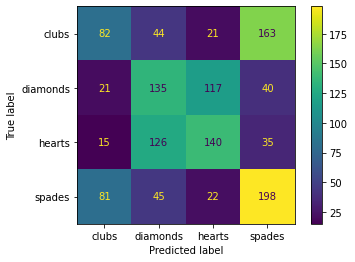

In [76]:
confusion = confusion_matrix(classes_valid_labels_hsv,predict_classes_valid_hsv)
disp = ConfusionMatrixDisplay(confusion,display_labels = class_names)
disp.plot()

### Logistic Regression Classification - Hue

In [77]:
train_labels_1d = np.argmax(train_labels,axis = 1)

# Create the logistic regression model
logreg = LogisticRegression(max_iter=2000, random_state=1)

logreg.fit(train_hsv_features, train_labels_1d)


LogisticRegression(max_iter=2000, random_state=1)

In [78]:
predict_classes_valid_hsv = logreg.predict(valid_hsv_features)

classes_valid_labels_hsv = np.argmax(valid_labels,axis=1)

In [79]:
# Get the class names from the generator (assuming it has the 'class_indices' attribute)
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

# Calculate classification report for validation set
valid_report = classification_report(classes_valid_labels_hsv, predict_classes_valid_hsv)
print("Validation Classification Report:\n", valid_report)

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.25      0.30       310
           1       0.37      0.35      0.36       313
           2       0.39      0.43      0.41       316
           3       0.45      0.58      0.51       346

    accuracy                           0.41      1285
   macro avg       0.40      0.40      0.40      1285
weighted avg       0.40      0.41      0.40      1285



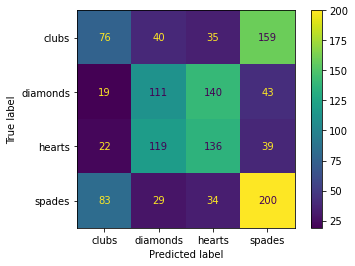

In [80]:
confusion = confusion_matrix(classes_valid_labels_hsv,predict_classes_valid_hsv)
disp = ConfusionMatrixDisplay(confusion,display_labels = class_names)
disp.plot()

### SVM Classification - Hue

In [189]:
train_labels_1d = np.argmax(train_labels,axis = 1)

# Create the SVM model
svm_model = SVC(C=1, kernel='rbf', random_state=1, verbose = 1)

svm_model.fit(train_hsv_features, train_labels_1d)



[LibSVM]

SVC(C=1, random_state=1, verbose=1)

In [190]:
predict_classes_valid_hsv = svm_model.predict(valid_hsv_features)

classes_valid_labels_hsv = np.argmax(valid_labels,axis=1)

In [191]:
# Get the class names from the generator (assuming it has the 'class_indices' attribute)
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

# Calculate classification report for validation set
valid_report = classification_report(classes_valid_labels_hsv, predict_classes_valid_hsv)
print("Validation Classification Report:\n", valid_report)

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.24      0.31       310
           1       0.37      0.34      0.35       313
           2       0.47      0.54      0.50       316
           3       0.47      0.64      0.54       346

    accuracy                           0.45      1285
   macro avg       0.44      0.44      0.43      1285
weighted avg       0.44      0.45      0.43      1285



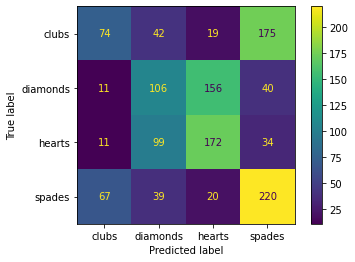

In [192]:
confusion = confusion_matrix(classes_valid_labels_hsv,predict_classes_valid_hsv)
disp = ConfusionMatrixDisplay(confusion,display_labels = class_names)
disp.plot()

### Random Forest Classification - Hue

In [85]:
train_labels_1d = np.argmax(train_labels,axis = 1)

#Create random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=1)

rf_classifier.fit(train_hsv_features, train_labels_1d)

RandomForestClassifier(random_state=1)

In [86]:
predict_classes_valid_hsv = rf_classifier.predict(valid_hsv_features)

classes_valid_labels_hsv = np.argmax(valid_labels,axis=1)

In [87]:
# Get the class names from the generator (assuming it has the 'class_indices' attribute)
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

# Calculate classification report for validation set
valid_report = classification_report(classes_valid_labels_hsv, predict_classes_valid_hsv)
print("Validation Classification Report:\n", valid_report)

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.28      0.34       310
           1       0.41      0.46      0.43       313
           2       0.46      0.46      0.46       316
           3       0.51      0.62      0.56       346

    accuracy                           0.46      1285
   macro avg       0.46      0.46      0.45      1285
weighted avg       0.46      0.46      0.45      1285



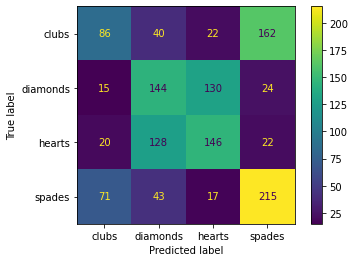

In [88]:
confusion = confusion_matrix(classes_valid_labels_hsv,predict_classes_valid_hsv)
disp = ConfusionMatrixDisplay(confusion,display_labels = class_names)
disp.plot()

## Review performance by model

In [194]:
# Define the list of models
models = [cnn, logreg, svm_model, rf_classifier]
model_names = ["cnn", "logreg", "svm_model", "rf_classifier"]

# Create an empty dictionary to store accuracies for each model
all_accuracies = {}

# Loop through each model
for model, model_names in zip(models,model_names):

    # Calculate accuracies for training and validation sets
    train_accuracies = compute_class_accuracies(model, train_hsv_features, train_labels_1d)
    valid_accuracies = compute_class_accuracies(model, valid_hsv_features, classes_valid_labels_hsv)
    
    # Store the accuracies in the dictionary
    all_accuracies[model_names] = {'Train': train_accuracies, 'Validation': valid_accuracies}


41/41 [==============================] - 0s 1ms/step


In [195]:
flattened_dict = {}
for model_name, model_data in all_accuracies.items():
    for mode, accuracy_list in model_data.items():
        print(accuracy_list)
        key = f"{mode.capitalize()}_{model_name}"
        flattened_dict[key] = accuracy_list
        

print(flattened_dict)
            
# Create a DataFrame from the flattened dictionary
df = pd.DataFrame(flattened_dict, index=class_names + ['Overall'])


[0.5448, 0.6925, 0.6203, 0.778, 0.6621]
[0.2645, 0.4313, 0.443, 0.5723, 0.4319]
[0.3535, 0.4601, 0.5166, 0.6471, 0.4986]
[0.2581, 0.3482, 0.4557, 0.578, 0.4148]
[0.4092, 0.4521, 0.6076, 0.7354, 0.5562]
[0.2387, 0.3387, 0.5443, 0.6358, 0.4451]
[0.8273, 0.9856, 0.9739, 1.0, 0.9484]
[0.2774, 0.4601, 0.462, 0.6214, 0.4599]
{'Train_cnn': [0.5448, 0.6925, 0.6203, 0.778, 0.6621], 'Validation_cnn': [0.2645, 0.4313, 0.443, 0.5723, 0.4319], 'Train_logreg': [0.3535, 0.4601, 0.5166, 0.6471, 0.4986], 'Validation_logreg': [0.2581, 0.3482, 0.4557, 0.578, 0.4148], 'Train_svm_model': [0.4092, 0.4521, 0.6076, 0.7354, 0.5562], 'Validation_svm_model': [0.2387, 0.3387, 0.5443, 0.6358, 0.4451], 'Train_rf_classifier': [0.8273, 0.9856, 0.9739, 1.0, 0.9484], 'Validation_rf_classifier': [0.2774, 0.4601, 0.462, 0.6214, 0.4599]}


In [196]:
df

,Train_cnn,Validation_cnn,Train_logreg,Validation_logreg,Train_svm_model,Validation_svm_model,Train_rf_classifier,Validation_rf_classifier
clubs,0.5448,0.2645,0.3535,0.2581,0.4092,0.2387,0.8273,0.2774
diamonds,0.6925,0.4313,0.4601,0.3482,0.4521,0.3387,0.9856,0.4601
hearts,0.6203,0.4430,0.5166,0.4557,0.6076,0.5443,0.9739,0.4620
spades,0.7780,0.5723,0.6471,0.5780,0.7354,0.6358,1.0000,0.6214
Overall,0.6621,0.4319,0.4986,0.4148,0.5562,0.4451,0.9484,0.4599


The most accurate model was the random forest classifier but overfitting is extreme.

The logistic regression model had the least amount of overfitting and accuracy not far off from the random forest so would go with that as the best model for this feature.

### hyperparameter search

In [171]:
num_classes = 4

# Define the hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Regularization parameter
    'max_iter': [2000, 3000, 4000]  # Maximum number of iterations
}

# Create the GridSearchCV object
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to your data
grid_search.fit(train_hsv_features, train_labels_1d)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


/Users/caseyhahn/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/caseyhahn/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

In [173]:
best_params

{'C': 0.01, 'max_iter': 2000}

### Logistic Regression Classification using grid search parameters - Hue

In [174]:
train_labels_1d = np.argmax(train_labels,axis = 1)

# Create the logistic regression model
logreg = LogisticRegression(max_iter=2000, random_state=1, C = .01)

logreg.fit(train_hsv_features, train_labels_1d)


LogisticRegression(C=0.01, max_iter=2000, random_state=1)

In [175]:
predict_classes_valid_hsv = logreg.predict(valid_hsv_features)

classes_valid_labels_hsv = np.argmax(valid_labels,axis=1)

In [176]:
# Get the class names from the generator (assuming it has the 'class_indices' attribute)
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

# Calculate classification report for validation set
valid_report = classification_report(classes_valid_labels_hsv, predict_classes_valid_hsv)
print("Validation Classification Report:\n", valid_report)

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.26      0.31       310
           1       0.38      0.35      0.36       313
           2       0.41      0.46      0.43       316
           3       0.46      0.58      0.51       346

    accuracy                           0.41      1285
   macro avg       0.41      0.41      0.40      1285
weighted avg       0.41      0.41      0.41      1285



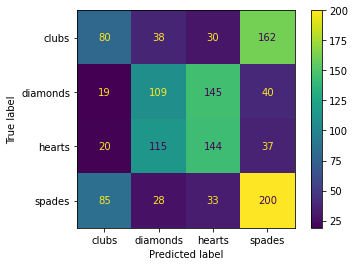

In [177]:
confusion = confusion_matrix(classes_valid_labels_hsv,predict_classes_valid_hsv)
disp = ConfusionMatrixDisplay(confusion,display_labels = class_names)
disp.plot()

### Final model on test data

In [181]:
predict_classes_test_hsv = logreg.predict(test_hsv_features)

classes_test_labels_hsv = np.argmax(test_labels,axis=1)

In [183]:
# Get the class names from the generator (assuming it has the 'class_indices' attribute)
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

# Calculate classification report for validation set
test_report = classification_report(classes_test_labels_hsv, predict_classes_test_hsv)
print("Test Classification Report:\n", test_report)

Test Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.29      0.33       387
           1       0.39      0.38      0.38       392
           2       0.43      0.44      0.44       395
           3       0.45      0.54      0.49       432

    accuracy                           0.42      1606
   macro avg       0.41      0.41      0.41      1606
weighted avg       0.41      0.42      0.41      1606



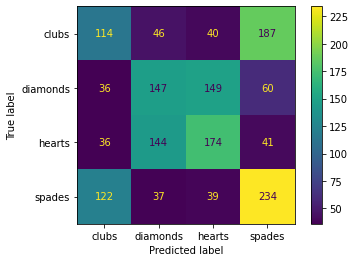

In [184]:
confusion = confusion_matrix(classes_test_labels_hsv,predict_classes_test_hsv)
disp = ConfusionMatrixDisplay(confusion,display_labels = class_names)
disp.plot()